In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
from tensorflow.keras.layers import Dense,Bidirectional,LSTM,SimpleRNN,Flatten,Lambda,Conv1D,MaxPooling1D,BatchNormalization,Activation,Concatenate,Input,Add
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error

In [2]:
class timeSeriesPredict:
  def __init__(self,countryName):
    self.country = countryName
  series = []
  model = 0
  x = []
  y = []
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  split_time = 0
  lr = .001
  optimizer = Adam(lr)
  loss = tf.keras.losses.MeanSquaredError()
  callbacks = []
  epochs = 500
  history = None


In [3]:
def get_series(file_path):
  sdate = datetime.datetime.strptime(starting_date, "%d%m%Y").date()
  with open(file_path) as f:
    reader = csv.reader(f,delimiter=',')
    next(reader)
    series = []
    c = 0
    dates = []
    for i in reader:
      try : 
        tmp = []
        tmp.append(float(i[5]))
        series.append(np.array(tmp))
        dates.append(sdate + datetime.timedelta(days = c))
        c += 1
      except:
        series.append(np.array([0]))
        dates.append(sdate + datetime.timedelta(days = c))
        c += 1
        continue
    series = np.vstack(series)
    return series,dates



def create_windowed_dataset(series, window,begin):
  # series is a numpy array with shape (m,n_features)
  # this function returns x and y
  # x -> windowed data, numpy array of shape (m,n_features)
  # y -> labels for x, numpy array with shape(m,)
  m, n_features = series.shape
  i = begin
  x = []
  y = []
  while i < m :
    tmp = np.zeros((window,n_features))
    j = 0 if i-window >= 0 else window - i;
    tmp[j:window,:] = series[max(0,i-window):i,:] 
    x.append(tmp)
    y.append(series[i])
    i += 1
  return np.array(x), np.array(y)

def train_test_split(ratio,x,y):
  split_time = int(x.shape[0] * ratio)
  return x[0:split_time,:],x[split_time:,:],y[0:split_time],y[split_time:]

def moving_average(series,window):
  x = []
  m = series.shape[0]
  for i in range(m):
    b = i - window//2
    e = i + window//2
    inc = 0 if b > 0 else -b
    e += inc
    b += inc
    dec = 0 if e < m else e-m+1
    b -= dec
    e -= dec
    # print(b,e)
    x.append(np.sum(series[b:e+1,:]) / window)
  return np.array(np.expand_dims(x,1)) 

def plot(series,dates,fig=(5,3),label=None,title=None,interval=10,rotation=30,xlabel="Time",ylabel="New Cases"):
  fig = plt.figure(figsize = fig)
  ax = fig.add_subplot(111)
  plt.style.use("fivethirtyeight")

  n_lines = 2
  diff_linewidth = 1.05
  alpha_value = 0.1

  if dates != None:
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.plot(dates,series,label = label,color='#00008B')
    
  else:
    ax.plot([*range(1,len(series)+1)],series,label = label,color='#00008B')
  i=0
  for column in (series):
    ax.fill_between(x=i if dates==None else dates[i],
                    y1=column,
                    y2=[0] * len(series),
                    color='#00008B',
                    alpha=0.2)
    i=i+1
  

  
 # ax.plot(series,label = label,color='#FE53BB')
  ax.grid(color='#2A3459')
  ax.set_title(title,color='red')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  # ax.spines['bottom'].set_color('red')
  # ax.spines['top'].set_color('red')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black',rotation=rotation)
  ax.yaxis.label.set_color('green')
  ax.tick_params(axis='y', colors='green')
  if label != None:
    ax.legend()
  plt.show()

def comp_plot(series1,series2,dates,figsize=(10,6),flabel='train',slabel='val',title=None,interval=10,rotation=30,pred=[]):

  
 # df.plot(marker='o', ax=ax, color=colors)

  plt.style.use("fivethirtyeight")
  
  


  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111)

  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))

  ax.grid(color='#2A3459')
  #ax.plot(series1,label = flabel)
  ax.plot(dates,series1,label = flabel,color='#00008B')
  



  
  z = dates+pred
  ax.plot(z,series2,label = slabel,color='#FFA500')
  
 
 
  



  ax.set_xlabel('Time')
  ax.set_ylabel('New Cases')
  ax.set_title(title,color='red')
  # ax.spines['bottom'].set_color('red')
  # ax.spines['top'].set_color('red')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black',rotation=rotation)
  ax.yaxis.label.set_color('green')
  ax.tick_params(axis='y', colors='green')
  #ax.legend()
  plt.legend(['True Cases','Predicted Cases'])

  plt.show()


def forecast(model,x,window,days,tmn,tstd):
  y = model.predict(x)
  print(y.shape)
  for i in range(days) : 
    m = y.shape[0]
    tmp = y[-window:m]
    tmp = np.expand_dims(tmp,[0])
    tmp = (tmp - tmn) / tstd
    y = np.append(y,model.predict(tmp),axis= 0)
  
  return y


def mape(y1,y2):
  
  error=0
  cnt=0
  for i in range(y1.shape[0]):
    if y1[i]!=0:
      error=error+np.abs(y1[i]-y2[i])/y1[i]
      cnt=cnt+1
  error=error/cnt
  #print(error)
  error=error*100
  #error=convert_to_tensor(error)

  return float(error)


def train_model(country):
  tf.keras.backend.clear_session()
  country.model.compile(loss=country.loss,metrics=['mse'],optimizer=country.optimizer)
  history = country.model.fit(x=country.x_train,y=country.y_train, validation_data = (country.x_val,country.y_val), epochs=country.epochs,verbose=1,batch_size=300,callbacks=country.callbacks)
  country.history = history
  # plot(history.history['mse'],None,fig=(12,6))
  # plot(history.history['val_mse'],None,fig=(12,6))
  

def show_plots(country):
  # plot(country.history.history['mse'],None,fig=(12,6),label='train_mse', title='train mse',xlabel="epochs",ylabel="mse")
  # plot(country.history.history['val_mse'],None,fig=(12,6), label='val_mse', title='val mse')
  y_actual=country.y
  y_predicted=country.model.predict(country.x)
  nRMSE_train=mean_squared_error(y_actual, y_predicted, squared=False)/np.mean(y_predicted)
  MAPE_train=mape(y_actual,y_predicted)
  comp_plot(country.y,country.model.predict(country.x),country.dates,
            title='entire series prediction',interval=interval,rotation=rotation)
  
  y_actual=country.y_val
  y_predicted=country.model.predict(country.x_val)
  nRMSE_val=mean_squared_error(y_actual, y_predicted, squared=False)/np.mean(y_predicted)
  MAPE_val=mape(y_actual,y_predicted)
  comp_plot(country.y_val,country.model.predict(country.x_val),country.dates[country.split_time:],
            title='Validation',interval=3,rotation=rotation)
  prediction_dates = []
  last = country.dates[-1];
  for i in range(1,41):
    prediction_dates.append(last+datetime.timedelta(days=i))
  comp_plot(country.y,forecast(country.model,country.x,window_size,40,0,1),country.dates,
            figsize=(12,10),title='Forecast',interval=interval,rotation=rotation,pred=prediction_dates)
  return nRMSE_train,nRMSE_val,MAPE_train,MAPE_val


In [7]:
def get_model():
  model = tf.keras.Sequential([
                               
                               Conv1D(32,3,1,activation='relu',input_shape=(window_size,n_features)),
                               Conv1D(64,3,1,activation='relu'),
                               Conv1D(128,3,1,activation='relu'),
                               Conv1D(256,3,1,activation='relu'),
                              #  Conv1D(512,3,1,activation='relu'),
                               Flatten(),
                              #  Dense(100),
                               Dense(10,activation='relu'),
                               Dense(1,activation='relu')
  ])
  return model

In [8]:
ratio = .9
window_size = 20
n_features = 1
interval = 10
rotation = 45

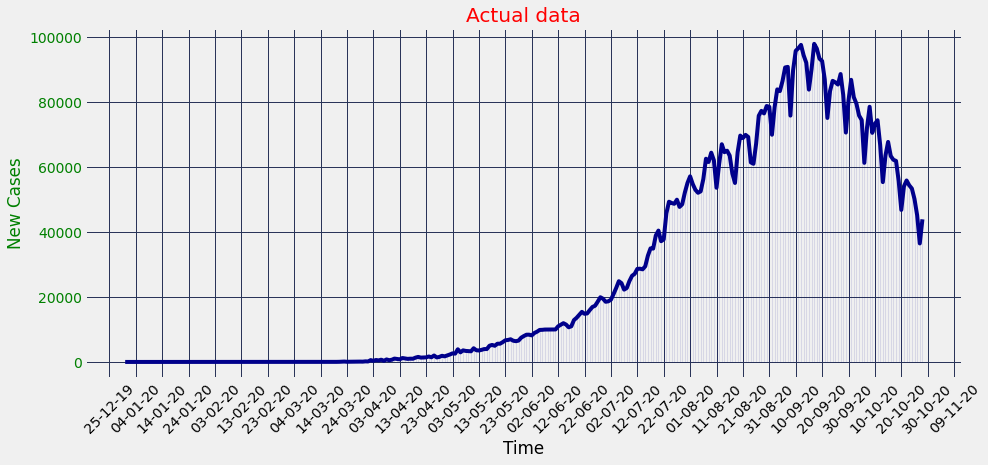

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 18, 32)            128       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 14, 128)           24704     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 12, 256)           98560     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30730     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [9]:
starting_date = "31122019"
india = timeSeriesPredict("india")
india.series,india.dates = get_series('/content/India.csv')
plot(india.series,india.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
india.series = moving_average(india.series,5)
plot(india.series,india.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
india.x,india.y = create_windowed_dataset(india.series,window_size,0)
india.x_train,india.x_val,india.y_train,india.y_val = train_test_split(ratio,india.x,india.y)
india.model = get_model()
india.model.summary()
india.epochs = 1000
india.split_time = int(india.x.shape[0] * ratio)

In [10]:
train_model(india)

Epoch 1/1000
1/1 [==============================] - 0s 215ms/step - loss: 1408012672.0000 - mse: 1408012672.0000 - val_loss: 2833241344.0000 - val_mse: 2833241344.0000
Epoch 2/1000
1/1 [==============================] - 0s 21ms/step - loss: 1000988544.0000 - mse: 1000988544.0000 - val_loss: 1251055488.0000 - val_mse: 1251055488.0000
Epoch 3/1000
1/1 [==============================] - 0s 20ms/step - loss: 571165440.0000 - mse: 571165440.0000 - val_loss: 37065096.0000 - val_mse: 37065096.0000
Epoch 4/1000
1/1 [==============================] - 0s 29ms/step - loss: 123156056.0000 - mse: 123156056.0000 - val_loss: 1717040256.0000 - val_mse: 1717040256.0000
Epoch 5/1000
1/1 [==============================] - 0s 21ms/step - loss: 115168480.0000 - mse: 115168480.0000 - val_loss: 3425318912.0000 - val_mse: 3425318912.0000
Epoch 6/1000
1/1 [==============================] - 0s 21ms/step - loss: 318979872.0000 - mse: 318979872.0000 - val_loss: 1916805888.0000 - val_mse: 1916805888.0000
Epoch 7/1

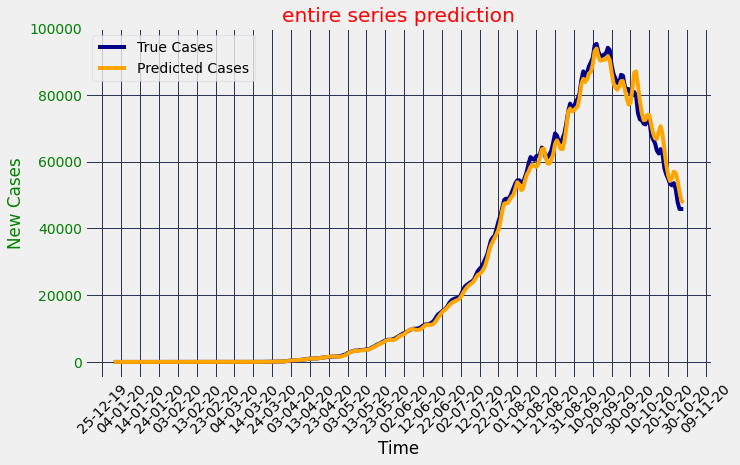

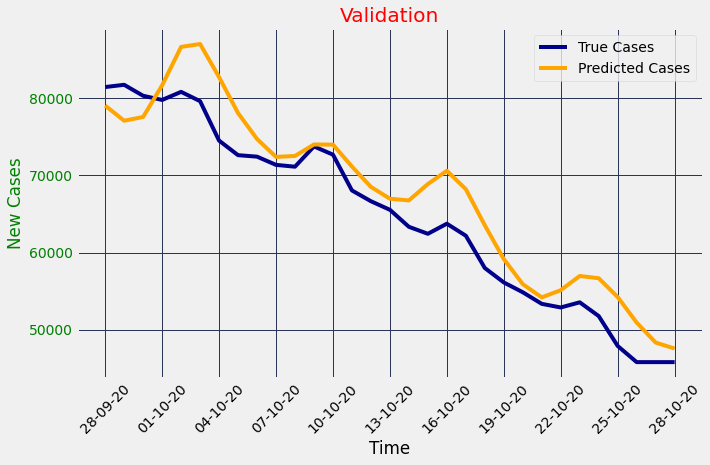

(303, 1)


(0.06319756300150019,
 0.06184533493171186,
 5.309859005158416,
 5.682859588256585)

In [11]:
show_plots(india)

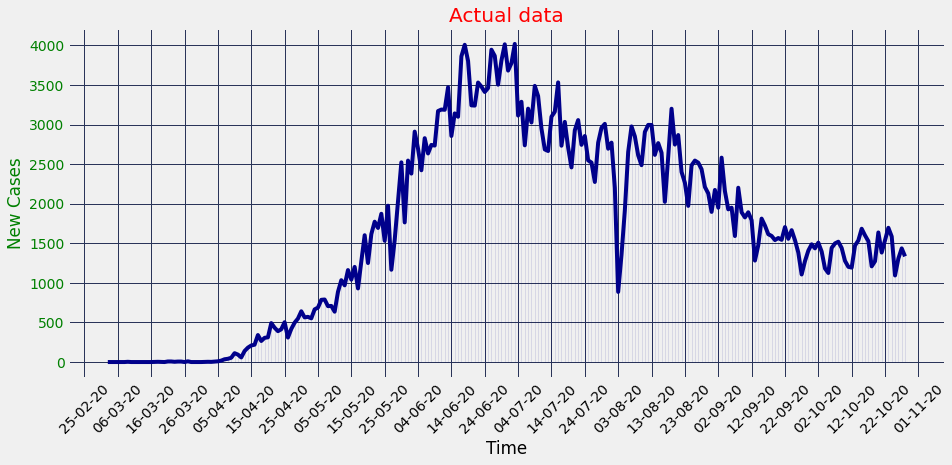

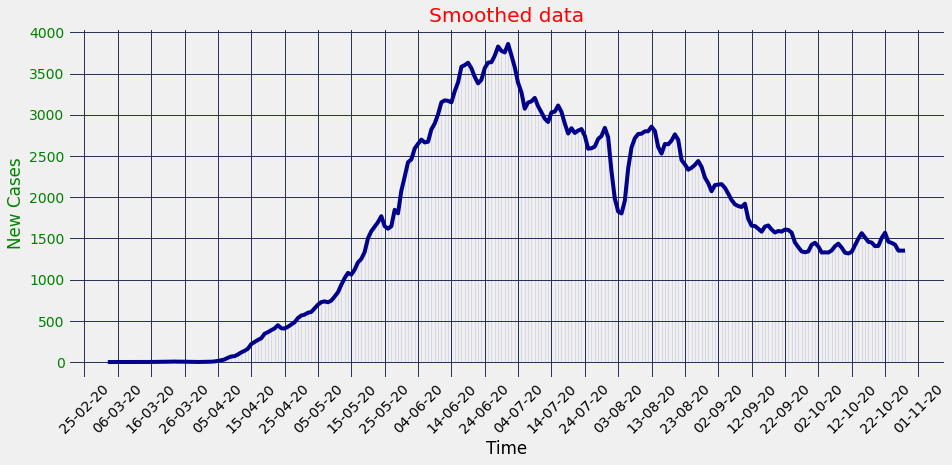

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 32)            128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 256)           98560     
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [16]:
starting_date = "03032020"
bangladesh = timeSeriesPredict("Bangladesh")
country = bangladesh
country.series,country.dates = get_series('/content/Bangladesh.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [17]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 166ms/step - loss: 3635953.7500 - mse: 3635953.7500 - val_loss: 1578285.0000 - val_mse: 1578285.0000
Epoch 2/1000
1/1 [==============================] - 0s 22ms/step - loss: 3565366.0000 - mse: 3565366.0000 - val_loss: 611065.6250 - val_mse: 611065.6250
Epoch 3/1000
1/1 [==============================] - 0s 23ms/step - loss: 1389686.3750 - mse: 1389686.3750 - val_loss: 720402.0625 - val_mse: 720402.0625
Epoch 4/1000
1/1 [==============================] - 0s 21ms/step - loss: 1614176.8750 - mse: 1614176.8750 - val_loss: 45053.8633 - val_mse: 45053.8633
Epoch 5/1000
1/1 [==============================] - 0s 21ms/step - loss: 212952.7188 - mse: 212952.7188 - val_loss: 2624095.2500 - val_mse: 2624095.2500
Epoch 6/1000
1/1 [==============================] - 0s 20ms/step - loss: 5818614.5000 - mse: 5818614.5000 - val_loss: 124768.1562 - val_mse: 124768.1562
Epoch 7/1000
1/1 [==============================] - 0s 20ms/step - loss: 374457.1

In [18]:
show_plots(bangladesh)


(240, 1)


(0.026170312414245965,
 0.03522835119052795,
 4.141216171053964,
 3.0002314746351746)

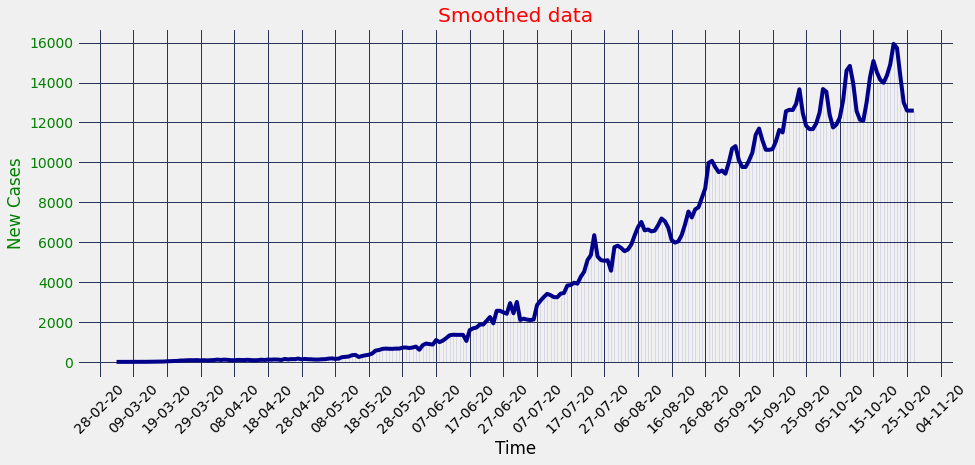

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 32)            128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 256)           98560     
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [19]:
starting_date = "04032020"
argentina = timeSeriesPredict("Argentina")
country = argentina
country.series,country.dates = get_series('/content/Argentina.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [20]:
train_model(argentina)

Epoch 1/1000
1/1 [==============================] - 0s 145ms/step - loss: 28592446.0000 - mse: 28592446.0000 - val_loss: 5418422.5000 - val_mse: 5418422.5000
Epoch 2/1000
1/1 [==============================] - 0s 20ms/step - loss: 1738393.0000 - mse: 1738393.0000 - val_loss: 2367974400.0000 - val_mse: 2367974400.0000
Epoch 3/1000
1/1 [==============================] - 0s 20ms/step - loss: 313058624.0000 - mse: 313058624.0000 - val_loss: 9264506.0000 - val_mse: 9264506.0000
Epoch 4/1000
1/1 [==============================] - 0s 29ms/step - loss: 705870.0000 - mse: 705870.0000 - val_loss: 103298664.0000 - val_mse: 103298664.0000
Epoch 5/1000
1/1 [==============================] - 0s 21ms/step - loss: 18073020.0000 - mse: 18073020.0000 - val_loss: 156923456.0000 - val_mse: 156923456.0000
Epoch 6/1000
1/1 [==============================] - 0s 21ms/step - loss: 26427930.0000 - mse: 26427930.0000 - val_loss: 165115104.0000 - val_mse: 165115104.0000
Epoch 7/1000
1/1 [=========================

(238, 1)


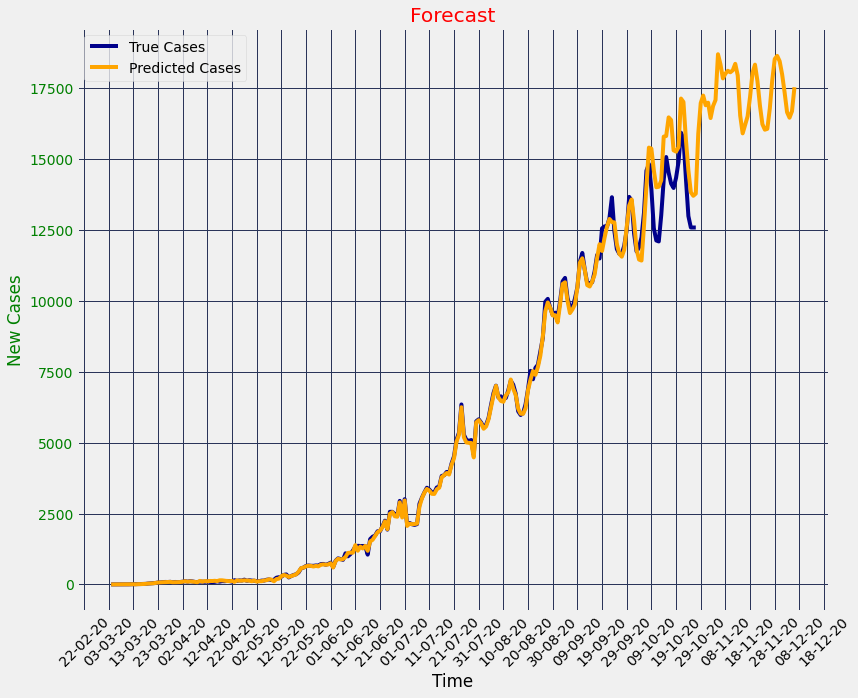

(0.09253847284724065,
 0.09088696077039148,
 6.085997434662506,
 9.121847768076526)

In [21]:
show_plots(argentina)

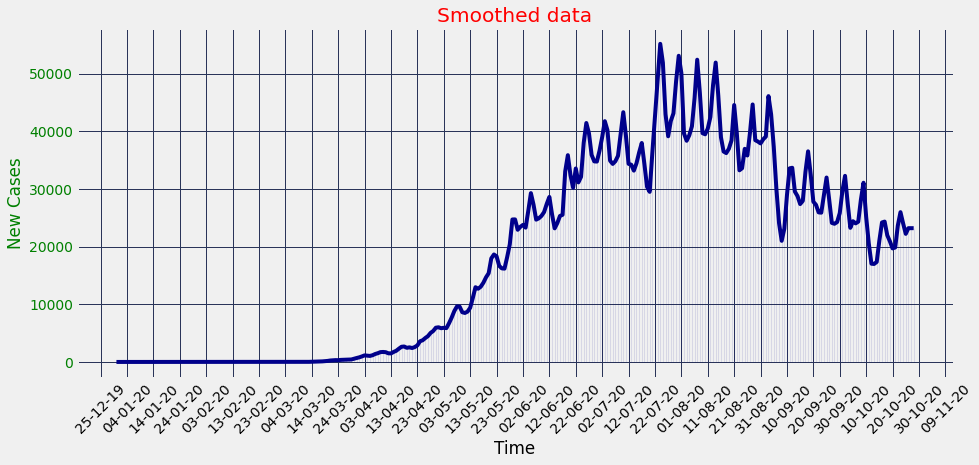

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 32)            128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 256)           98560     
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [22]:
starting_date = "31122019"
brazil = timeSeriesPredict("Brazil")
country = brazil
country.series,country.dates = get_series('/content/Brazil.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [23]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 175ms/step - loss: 596416960.0000 - mse: 596416960.0000 - val_loss: 32768896.0000 - val_mse: 32768896.0000
Epoch 2/1000
1/1 [==============================] - 0s 22ms/step - loss: 23958208.0000 - mse: 23958208.0000 - val_loss: 12579436.0000 - val_mse: 12579436.0000
Epoch 3/1000
1/1 [==============================] - 0s 24ms/step - loss: 24677548.0000 - mse: 24677548.0000 - val_loss: 899140864.0000 - val_mse: 899140864.0000
Epoch 4/1000
1/1 [==============================] - 0s 23ms/step - loss: 639882560.0000 - mse: 639882560.0000 - val_loss: 70754824.0000 - val_mse: 70754824.0000
Epoch 5/1000
1/1 [==============================] - 0s 27ms/step - loss: 107890040.0000 - mse: 107890040.0000 - val_loss: 310128832.0000 - val_mse: 310128832.0000
Epoch 6/1000
1/1 [==============================] - 0s 23ms/step - loss: 350031040.0000 - mse: 350031040.0000 - val_loss: 385272864.0000 - val_mse: 385272864.0000
Epoch 7/1000
1/1 [=============

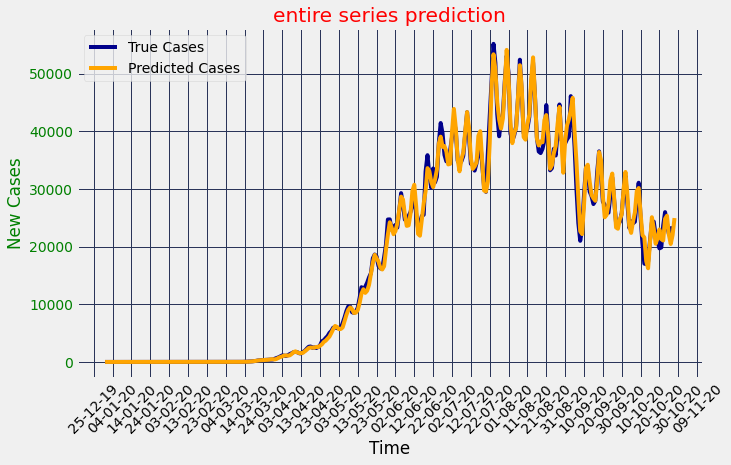

(303, 1)


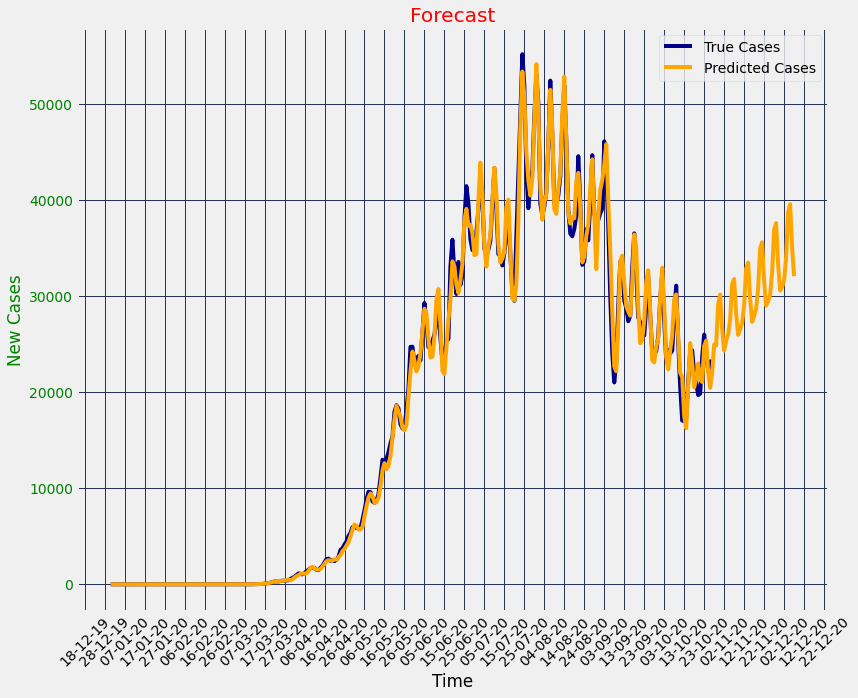

(0.0683574787371135, 0.06672629132479851, 8.20099927896173, 5.7261022577518395)

In [24]:
show_plots(brazil)

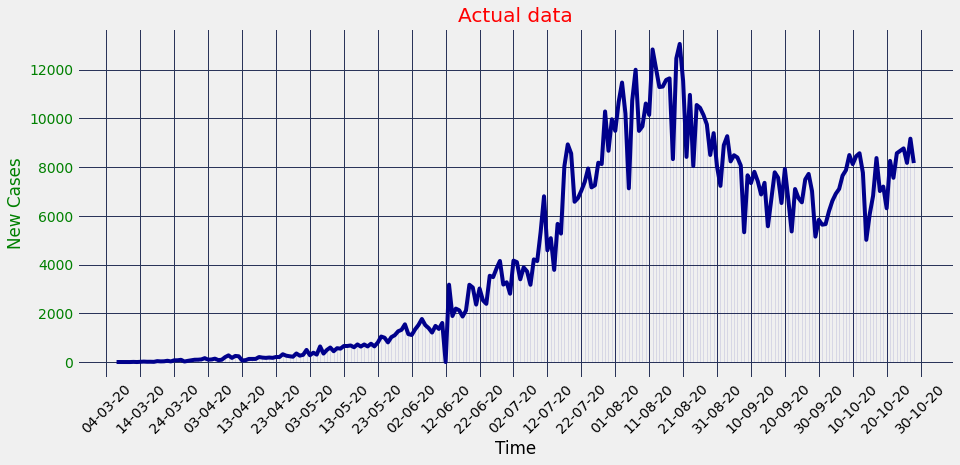

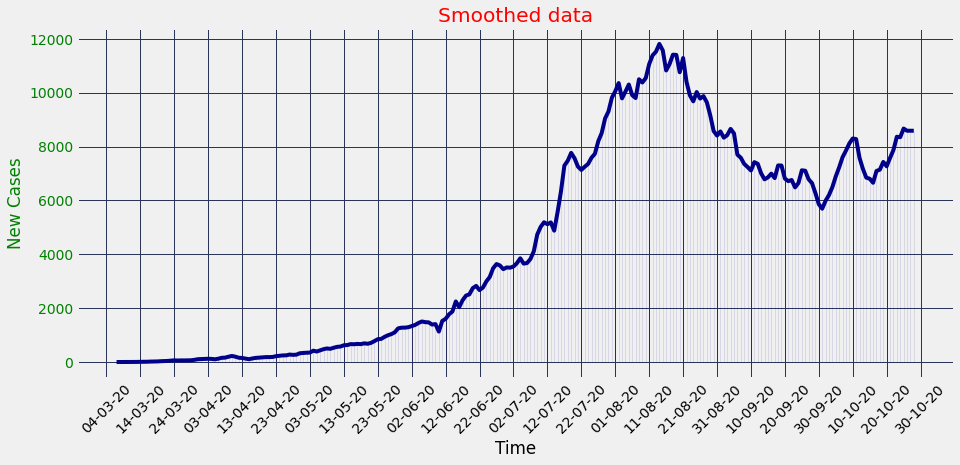

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 32)            128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 256)           98560     
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [25]:
starting_date = "07032020"
colombia = timeSeriesPredict("Colombia")
country = colombia
country.series,country.dates = get_series('/content/Colombia.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [26]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 145ms/step - loss: 30937942.0000 - mse: 30937942.0000 - val_loss: 53608596.0000 - val_mse: 53608596.0000
Epoch 2/1000
1/1 [==============================] - 0s 21ms/step - loss: 27351776.0000 - mse: 27351776.0000 - val_loss: 42321312.0000 - val_mse: 42321312.0000
Epoch 3/1000
1/1 [==============================] - 0s 21ms/step - loss: 29388302.0000 - mse: 29388302.0000 - val_loss: 17218694.0000 - val_mse: 17218694.0000
Epoch 4/1000
1/1 [==============================] - 0s 22ms/step - loss: 8322205.0000 - mse: 8322205.0000 - val_loss: 24496488.0000 - val_mse: 24496488.0000
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - loss: 12106279.0000 - mse: 12106279.0000 - val_loss: 8315852.0000 - val_mse: 8315852.0000
Epoch 6/1000
1/1 [==============================] - 0s 21ms/step - loss: 4010468.2500 - mse: 4010468.2500 - val_loss: 9255476.0000 - val_mse: 9255476.0000
Epoch 7/1000
1/1 [==============================] - 0

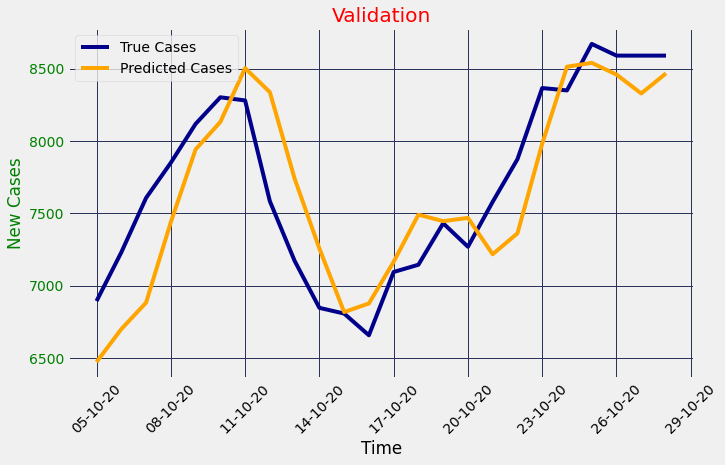

(236, 1)


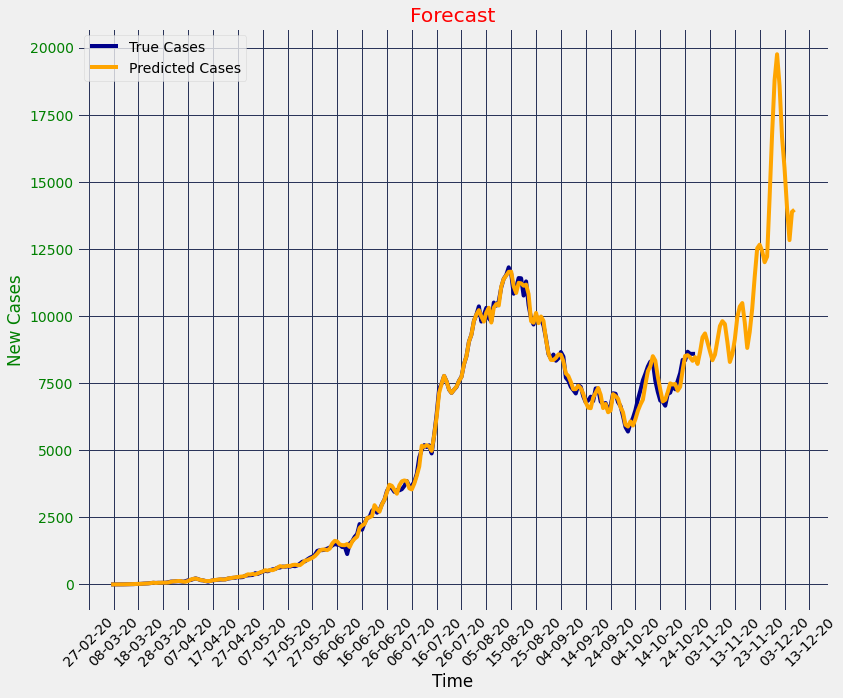

(0.03638883722267505,
 0.04787902810286576,
 3.7593186299619434,
 4.021490480021409)

In [27]:
show_plots(colombia)

In [28]:
starting_date = "31122019"
uk = timeSeriesPredict("UK")
country = uk
country.series,country.dates = get_series('/content/United Kingdom.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 32)            128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 256)           98560     
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [29]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 162ms/step - loss: 5127707.5000 - mse: 5127707.5000 - val_loss: 140086048.0000 - val_mse: 140086048.0000
Epoch 2/1000
1/1 [==============================] - 0s 22ms/step - loss: 2323036.2500 - mse: 2323036.2500 - val_loss: 97313576.0000 - val_mse: 97313576.0000
Epoch 3/1000
1/1 [==============================] - 0s 21ms/step - loss: 6426188.5000 - mse: 6426188.5000 - val_loss: 71952104.0000 - val_mse: 71952104.0000
Epoch 4/1000
1/1 [==============================] - 0s 20ms/step - loss: 1117708.6250 - mse: 1117708.6250 - val_loss: 163661632.0000 - val_mse: 163661632.0000
Epoch 5/1000
1/1 [==============================] - 0s 19ms/step - loss: 2795665.0000 - mse: 2795665.0000 - val_loss: 183779328.0000 - val_mse: 183779328.0000
Epoch 6/1000
1/1 [==============================] - 0s 26ms/step - loss: 3214444.0000 - mse: 3214444.0000 - val_loss: 164161408.0000 - val_mse: 164161408.0000
Epoch 7/1000
1/1 [==============================]

(303, 1)


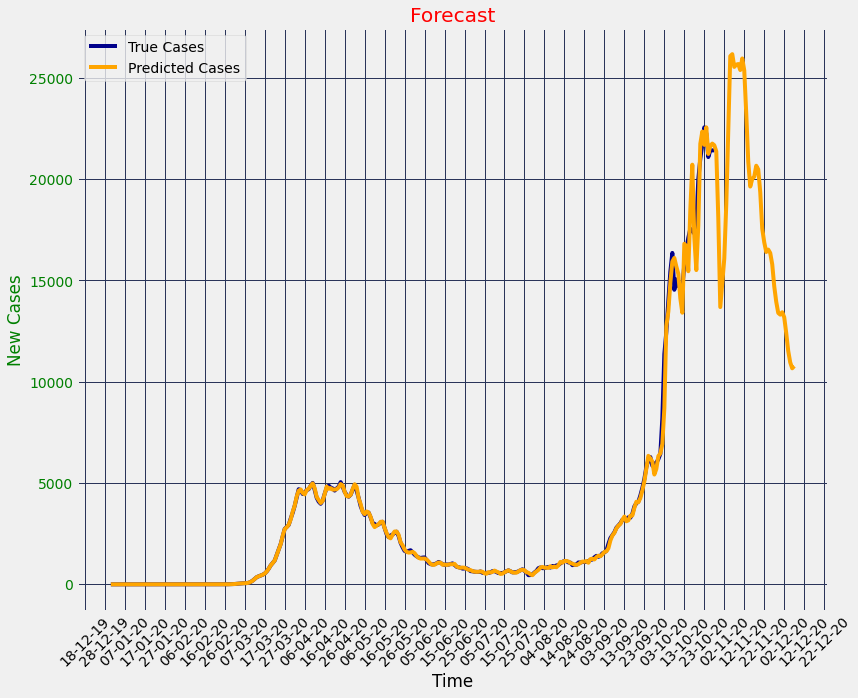

(0.12514302561078466, 0.07478058440155702, 12.0000723011343, 5.844677941785853)

In [30]:
show_plots(uk)

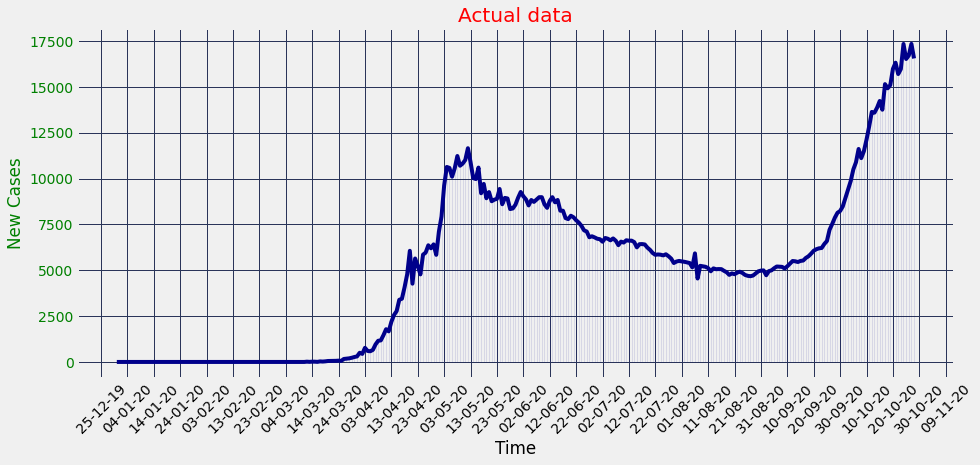

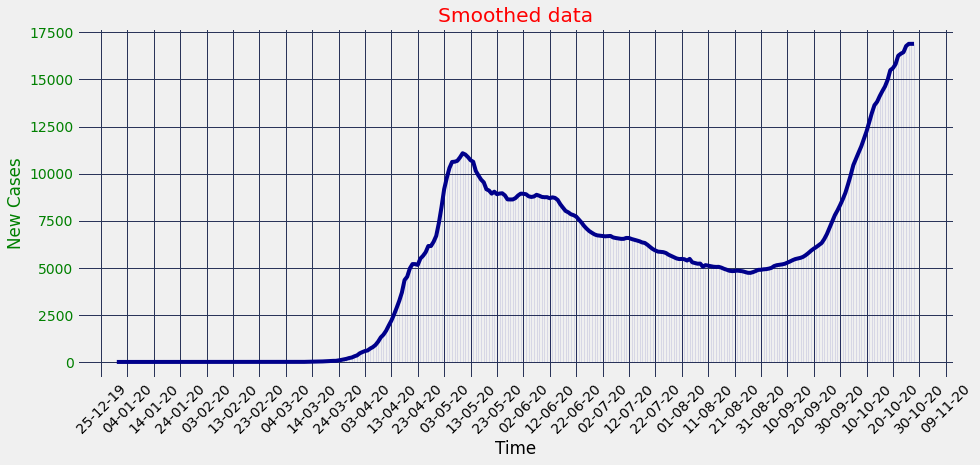

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 32)            128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 256)           98560     
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [31]:
starting_date = "31122019"
russia = timeSeriesPredict("Russia")
country = russia
country.series,country.dates = get_series('/content/Russia.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [32]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 137ms/step - loss: 30200664.0000 - mse: 30200664.0000 - val_loss: 12324102.0000 - val_mse: 12324102.0000
Epoch 2/1000
1/1 [==============================] - 0s 21ms/step - loss: 1331490.3750 - mse: 1331490.3750 - val_loss: 1106476928.0000 - val_mse: 1106476928.0000
Epoch 3/1000
1/1 [==============================] - 0s 23ms/step - loss: 346498208.0000 - mse: 346498208.0000 - val_loss: 21770472.0000 - val_mse: 21770472.0000
Epoch 4/1000
1/1 [==============================] - 0s 21ms/step - loss: 2050336.2500 - mse: 2050336.2500 - val_loss: 169376256.0000 - val_mse: 169376256.0000
Epoch 5/1000
1/1 [==============================] - 0s 21ms/step - loss: 28702516.0000 - mse: 28702516.0000 - val_loss: 178749248.0000 - val_mse: 178749248.0000
Epoch 6/1000
1/1 [==============================] - 0s 22ms/step - loss: 30201262.0000 - mse: 30201262.0000 - val_loss: 178749248.0000 - val_mse: 178749248.0000
Epoch 7/1000
1/1 [===================

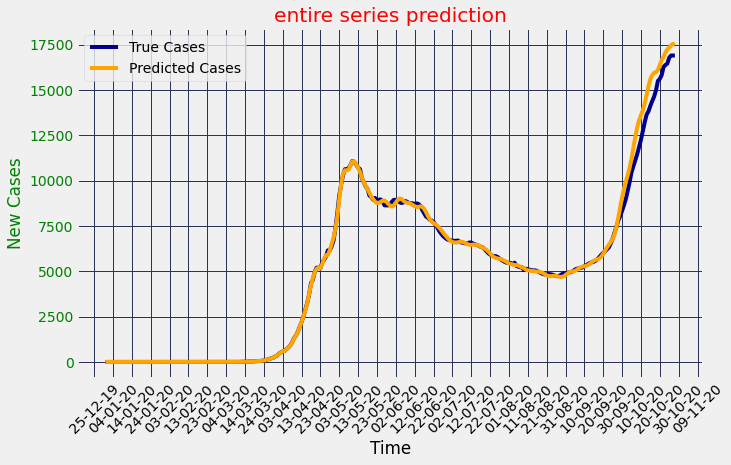

(303, 1)


(0.06229600707041576,
 0.07063708359297213,
 6.606438582164585,
 7.456219082608705)

In [33]:
show_plots(russia)

In [ ]:
# model = tf.keras.Sequential([
                               
  #                              Conv1D(32,3,1,input_shape=(window_size,n_features)),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                              Conv1D(64,3,1),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                              Conv1D(128,3,1),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                              Conv1D(256,3,1),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                             #  Conv1D(512,3,1,activation='relu'),
  #                             #  BatchNormalization(),
  #                             #  Activation('relu'),
  #                             #  Conv1D(1024,3,1,activation='relu'),
  #                              Flatten(),
  #                             #  Dense(100),
  #                              Dense(10),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                              Dense(1,activation='relu')
  # ])

  # input = Input(shape=(window_size,n_features))
  # x = Conv1D(32,3,1)(input)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # x = inception_A(x)
  # x = Conv1D(64,3,1)(x)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # x = inception_A(x)
  # x = Conv1D(128,3,1)(x)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # x = inception_A(x)
  # x = Conv1D(256,3,1)(x)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # # x = LSTM(8)(x)
  # x = Flatten()(x)
  # x = Dense(10)(x)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # x = Dense(1,activation='relu')(x)

  # model = Model(input,x)

In [ ]:
def inception_A(x):
  p1 = Conv1D(64,3,1,padding='same')(x)
  p2 = Conv1D(64,5,1,padding='same')(x)
  p3 = Conv1D(64,7,1,padding='same')(x)
  p4 = Conv1D(64,9,1,padding='same')(x)
  x = Add()([p1,p2,p3,p4])
  # x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x


In [ ]:
series,time = get_series('/content/Bangladesh.csv')
series = moving_average(series,5)
print(len(series))
plot(series,fig=(10,6))

In [ ]:
def scheduler(epoch , lr):
    lr = .01;
    c = int(epoch / 1000);
    lr /= 1 if c < 1 else c*10
    return lr

lr_reg = tf.keras.callbacks.LearningRateScheduler(scheduler)
tf.keras.backend.clear_session()
# model = get_model()
epochs = 1000
opt = Adam(learning_rate=.001)
# opt = SGD(lr=.1)
loss = tf.keras.losses.MeanSquaredError()
# loss = tf.keras.losses.Huber(delta = 1000)
model.compile(loss=loss,metrics=['mse'],optimizer=opt)
history = model.fit(x=x_train,y=y_train, validation_data = (x_val,y_val), epochs=epochs,verbose=1,batch_size=300)#,callbacks=[lr_reg])
# plot(history.history['loss'],0,1000)
plot(history.history['mse'],0,epochs,fig=(12,6))
plot(history.history['val_mse'],0,epochs,fig=(12,6))

In [ ]:
comp_plot(india.y_val,india.model.predict(india.x_val))

In [ ]:
ratio = .85
window_size = 20
n_features = series.shape[1]
x,y = create_windowed_dataset(series,window_size,0)
split_time = int(x.shape[0] * ratio)
# tmn,tstd = np.mean(x[0:split_time,:]),np.linalg.norm(x[0:split_time,:])
# vmn,vstd = np.mean(x[split_time:,:]),np.linalg.norm(x[split_time:,:])
# x = (x - tmn) / tstd
x_train,x_val,y_train,y_val = train_test_split(ratio,x,y)

In [ ]:
comp_plot(india.y,india.model.predict(india.x))

In [ ]:
comp_plot(india.y,forecast(india.model,india.x,window_size,40,0,1),figsize=(12,10))

In [ ]:
plot(india.history.history['mse'],500,india.epochs,fig=(12,6))
plot(india.history.history['val_mse'],500,india.epochs,fig=(12,6))

In [ ]:
model = get_model()
model.summary()

In [ ]:
plt.plot([1,2,3],label = "this is ")
plt.xlabel('Eposchs')
plt.legend()

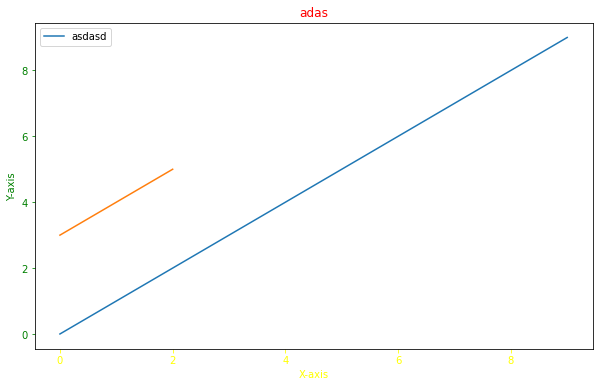

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(range(10),label = "asdasd")
ax.plot([3,4,5])
ax.legend()
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title("adas",color='red')
# ax.spines['bottom'].set_color('blue')
# ax.spines['top'].set_color('blue')
ax.xaxis.label.set_color('yellow')
ax.tick_params(axis='x', colors='yellow')
ax.yaxis.label.set_color('green')
ax.tick_params(axis='y', colors='green')

plt.show()